# MotiHomeT: Algorithm

### Import Libraries

In [1]:
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit as sigmoid
import tensorflow as tf

### Base Settings

In [2]:
SAMPLE_INTERVAL = 30 # ms

BODY_PARTS = [
    'NOSE',
    'LEFT_EYE',
    'RIGHT_EYE',
    'LEFT_EAR',
    'RIGHT_EAR',
    'LEFT_SHOULDER',
    'RIGHT_SHOULDER',
    'LEFT_ELBOW',
    'RIGHT_ELBOW',
    'LEFT_WRIST',
    'RIGHT_WRIST',
    'LEFT_HIP',
    'RIGHT_HIP',
    'LEFT_KNEE',
    'RIGHT_KNEE',
    'LEFT_ANKLE',
    'RIGHT_ANKLE',
]

USING_PARTS = [
    'SHOULDER',
    'WRIST',
    'HIP',
    'KNEE',
    'ANKLE',
]

BODY_JOINTS = [
    ('LEFT_WRIST', 'LEFT_ELBOW'),
    ('LEFT_ELBOW', 'LEFT_SHOULDER'),
    ('LEFT_SHOULDER', 'RIGHT_SHOULDER'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'),
    ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('LEFT_SHOULDER', 'LEFT_HIP'),
    ('LEFT_HIP', 'RIGHT_HIP'),
    ('RIGHT_HIP', 'RIGHT_SHOULDER'),
    ('LEFT_HIP', 'LEFT_KNEE'),
    ('LEFT_KNEE', 'LEFT_ANKLE'),
    ('RIGHT_HIP', 'RIGHT_KNEE'),
    ('RIGHT_KNEE', 'RIGHT_ANKLE')
]

NUM_BODY_PARTS = len(BODY_PARTS)
BODY_PART_TO_IDX = {body_part:idx for idx, body_part in enumerate(BODY_PARTS)}
IDX_TO_BODY_PART = {idx:body_part for idx, body_part in enumerate(BODY_PARTS)}
BODY_JOINTS_IDX = [(BODY_PART_TO_IDX[joint1], BODY_PART_TO_IDX[joint2]) for joint1, joint2 in BODY_JOINTS]

### Load Functions

In [3]:
def get_pushup_types(person: str):
    return [dirpath.split('/')[-1] for dirpath in glob(f'{person}_processed/*')]
    

def get_framenums(person: str, pushup_type: str):
    filepaths = glob(f'{person}_processed/{pushup_type}/*.png')
    return sorted([int(filepath.split('/')[-1][:-4]) for filepath in filepaths])

def get_image(person: str, pushup_type: str, framenum: int):
    image_path = f'{person}_processed/{pushup_type}/{framenum}.png'
    img = cv2.imread(image_path)[:,:,[2,1,0]]
    return img


persons = ['hyunwoo', 'changmin']
pushup_types_dict = {person: get_pushup_types(person) for person in persons}
framenums_dict = {(person, pushup_type): get_framenums(person, pushup_type)
    for person in persons for pushup_type in pushup_types_dict[person]}

### Inference with TensorFlow Lite

In [4]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="posenet_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

def inference(img: np.ndarray, rotate: bool = True) -> np.ndarray:
    if rotate:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

    img = img.astype(np.float)
    img = (img - 128) / 128
    
    # Test the model on random input data.
    input_data = np.array(img, dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data.reshape(input_shape))

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    heatmaps = interpreter.get_tensor(output_details[0]['index'])
    offsets = interpreter.get_tensor(output_details[1]['index'])

    height = heatmaps[0].shape[0]
    width = heatmaps[0][0].shape[0]
    num_keypoints = heatmaps[0][0][0].shape[0]

    keypoint_positions = []
    for keypoint in range(num_keypoints):
        max_val = heatmaps[0][0][0][keypoint]
        max_row = 0
        max_col = 0
        for row in range(height):
            for col in range(width):
                if heatmaps[0][row][col][keypoint] > max_val:
                    max_val = heatmaps[0][row][col][keypoint]
                    max_row = row
                    max_col = col
        keypoint_positions.append((max_row, max_col))

    result = []
    for i, (y_idx, x_idx) in enumerate(keypoint_positions):
        y_pos = int(y_idx / (height - 1) * img.shape[0] + offsets[0][y_idx][x_idx][i])
        x_pos = int(x_idx / (width - 1) * img.shape[1] + offsets[0][y_idx][x_idx][i + num_keypoints])
        confidence_score = sigmoid(heatmaps[0][y_idx][x_idx][i])

        if rotate:
            result.append((y_pos, img.shape[1] - x_pos, confidence_score))
        else:
            result.append((x_pos, y_pos, confidence_score))
    return np.asarray(result)

### Visualization

In [5]:
def draw_skeleton(inference_result, ax):
    for x, y, score in inference_result:
        ax.scatter(x, y, color='r')
    
    for joint1, joint2 in BODY_JOINTS_IDX:
        x1, y1, score1 = inference_result[joint1]
        x2, y2, score2 = inference_result[joint2]
        ax.plot([x1, x2], [y1, y2], color='r')

### Test

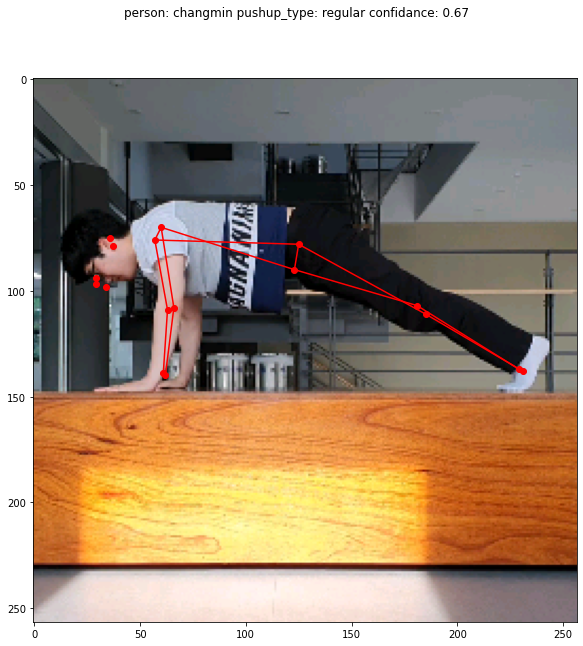

In [6]:
person = 'changmin'
pushup_type = 'regular'

fig, ax = plt.subplots(figsize=(10,10))

img = get_image(person, pushup_type, 0)
ax.imshow(img)
result = inference(img)
draw_skeleton(result, ax)

fig.suptitle(f'person: {person} pushup_type: {pushup_type} confidance: {np.average(result[:,2]) :.2f}')
plt.show()

### Function for Inference Images

In [7]:
def get_pos_sequence(person, pushup_type):
    framenums = get_framenums(person, pushup_type)
    results = []
    for frame in framenums:
        img = get_image(person, pushup_type, frame)
        result = inference(img)[np.newaxis, ...]
        results.append(result)
    return np.vstack(results)

### Inference or Load

In [8]:
import os
import pickle

save_filename = 'pos_sequences.pkl'
if os.path.exists(save_filename):
    with open(save_filename, 'rb') as f:
        pos_sequences = pickle.load(f)
else:
    pos_sequences = {}
    for person in persons:
        for pushup_type in get_pushup_types(person):
            pos_sequences[(person, pushup_type)] = get_pos_sequence(person, pushup_type)
    
    with open(save_filename, 'wb') as f:
        pickle.dump(pos_sequences, f)

### Loaded data

In [9]:
for key, value in pos_sequences.items():
    print(key, np.average(value[:,:,2]))

('hyunwoo', 'frontal_view') 0.35975166327126246
('hyunwoo', 'false_medium') 0.7292700781432512
('hyunwoo', 'left_side_arm') 0.1669106646339626
('hyunwoo', 'regular') 0.7349275858455019
('hyunwoo', 'degree_45_wide') 0.6699818624919994
('hyunwoo', 'both_side_arm') 0.25126538553415356
('hyunwoo', 'false_knee_on_bottom') 0.7407336155575033
('hyunwoo', 'table') 0.1202783928847804
('hyunwoo', 'false_wall') 0.3272803820053184
('hyunwoo', 'false_form') 0.6986463595271543
('hyunwoo', 'false_laying_on_floor') 0.6840494565854522
('hyunwoo', 'degree_45_narrow') 0.6256110562359022
('hyunwoo', 'rear_view') 0.32355414892810236
('hyunwoo', 'false_small') 0.7024933954565955
('changmin', 'frontal_view') 0.28730312940865577
('changmin', 'false_medium') 0.6777364537650808
('changmin', 'narrow') 0.6955656634616421
('changmin', 'left_side_arm') 0.2825648836422106
('changmin', 'regular') 0.6456204209003656
('changmin', 'degree_45_wide') 0.5408346180646475
('changmin', 'both_side_arm') 0.3314710037006087
('ch

# Pushup Counter class

In [10]:
from collections import deque

    
class PushupCounter:
    def __init__(self):
        self.idx = None
        self.inference_result = None
        
        # Posenet Calibration
        self.direction = None # LEFT or RIGHT
        self.window_size = 1000 // SAMPLE_INTERVAL
        self.unit_lengths = deque()
        self.calibrated_unit_length = None
        self.y_shoulders = deque()
        self.calibrated_y_shoulder = None
        
        # Count Calibration
        self.total_count = 0
        self.camera_error_count = 0
        self.pose_error_count = 0
        
        self.confidence_error_count = 0
        self.shoulder_distance_error_count = 0
        
        self.body_angle_error_count = 0
        self.hip_angle_error_count = 0
        self.knee_angle_error_count = 0
        
        # Thresholds
        self.confidence_threshold = 0.5
        self.shoulder_distance_threshold = 0.15
        self.error_rate_threshold = 0.5
        
        # Count
        self.num_count = 0
        self.y_max = 0
        self.y_min = 1000
        self.count_y_shoulder_threshold = 0.15
        self.down_check = False
    
        self.sum_unit_length = 0
    
    def count(self, inference_result, idx=0) -> int:
        self.idx = idx
        self.inference_result = inference_result
        self._initialize_values()

        self.total_count += 1
        if self._is_camera_error(): # Check camera error
            self.camera_error_count += 1
        elif self._is_pose_error(): # Check pose error
            self.pose_error_count += 1
        else: # No error
            self._check_state()
        
        return self.num_count
    
    
    def _is_camera_error(self) -> bool:
        # Check confidence
        num_high_confidence_parts = np.sum([self._get_score(f'{self.direction}_{body_part}') > self.confidence_threshold
                                            for body_part in USING_PARTS])
        if len(USING_PARTS) - num_high_confidence_parts > 1:
#             print(f'{self.idx} Camera Error: confidence error, {len(USING_PARTS)} - {num_high_confidence_parts} > 1')
            self.confidence_error_count += 1
            return True
        
        # Check distance between shoulders
        l_pos = self._get_xy('LEFT_SHOULDER')
        r_pos = self._get_xy('RIGHT_SHOULDER')
        if np.linalg.norm(l_pos - r_pos) > self.shoulder_distance_threshold * self.calibrated_unit_length:
#             print(f'{self.idx} Camera Error: shoulder distance error, {np.linalg.norm(l_pos - r_pos)}')
            self.shoulder_distance_error_count += 1
            return True
        return False
    
    
    def _is_pose_error(self) -> bool:
        body_angle = self._calc_angle('WRIST', 'ANKLE', 'SHOULDER')
        if not (5 < body_angle and body_angle < 30):
#             print(f'{self.idx} Pose Error: body angle error, {body_angle}')
            self.body_angle_error_count += 1
            return True
        
        hip_angle = self._calc_angle('KNEE', 'HIP', 'SHOULDER')
        if not (150 < hip_angle and hip_angle < 190):
#             print(f'{self.idx} Pose Error: hip angle error, {hip_angle}')
            self.hip_angle_error_count += 1
            return True
        
        knee_angle = self._calc_angle('ANKLE', 'KNEE', 'HIP')
        if not (160 < knee_angle and knee_angle < 210):
#             print(f'{self.idx} Pose Error: knee angle error, {knee_angle}')
            self.knee_angle_error_count += 1
            return True
        return False
        
    
    def _check_state(self) -> bool:
        if self.y_max < self.calibrated_y_shoulder:
            self.y_max = self.calibrated_y_shoulder
        if self.y_min > self.calibrated_y_shoulder:
            self.y_min = self.calibrated_y_shoulder
        if self.y_max - self.y_min > self.count_y_shoulder_threshold * self.calibrated_unit_length:
            if self.down_check and self.y_min != self.calibrated_y_shoulder:
                if (self.camera_error_count + self.pose_error_count) / self.total_count < self.error_rate_threshold:
                    self.num_count += 1
                self._reset_count()
            else:
                self.down_check = True
            self.y_min = self.calibrated_y_shoulder
            self.y_max = self.calibrated_y_shoulder
            
    def _reset_count(self):
        self.total_count = 0
        self.camera_error_count = 0
        self.pose_error_count = 0    
    
    def _initialize_values(self):
        self.direction = self._get_direction()
        self.calibrated_unit_length = self._get_unit_length()
        self.calibrated_y_shoulder = self._get_y_shoulder()
    

    def _get_direction(self) -> str:
        x_shoulder = np.average([self._get_xy(body_part)[0] for body_part in ['LEFT_SHOULDER', 'RIGHT_SHOULDER']])
        x_ankle = np.average([self._get_xy(body_part)[0] for body_part in ['LEFT_ANKLE', 'RIGHT_ANKLE']])
        if x_ankle > x_shoulder:
            return 'LEFT'
        else:
            return 'RIGHT'


    def _get_unit_length(self) -> float:
        pos_shoulder = self._get_xy(f'{self.direction}_SHOULDER')
        pos_hip = self._get_xy(f'{self.direction}_HIP')
        pos_knee = self._get_xy(f'{self.direction}_KNEE')
        pos_ankle = self._get_xy(f'{self.direction}_ANKLE')
        unit_length = np.linalg.norm(pos_shoulder-pos_hip) + np.linalg.norm(pos_hip-pos_knee) + np.linalg.norm(pos_knee-pos_ankle)
        self.sum_unit_length += unit_length
        self.unit_lengths.append(unit_length)
        if len(self.unit_lengths) > self.window_size:
            self.unit_lengths.popleft()
        return sorted(self.unit_lengths)[min(len(self.unit_lengths), self.window_size)//2]


    def _get_y_shoulder(self) -> float:
        y_shoulder = self._get_xy(f'{self.direction}_SHOULDER')[1]
        self.y_shoulders.append(y_shoulder)
        if len(self.y_shoulders) > self.window_size:
            self.y_shoulders.popleft()
        return sorted(self.y_shoulders)[min(len(self.y_shoulders), self.window_size)//2]
        
        
    # Utils
    def _get_xy(self, body_part: str) -> (float, float):
        return self.inference_result[BODY_PART_TO_IDX[body_part], [0,1]]
        
        
    def _get_score(self, body_part: str) -> float:
        return self.inference_result[BODY_PART_TO_IDX[body_part], 2]
    
    
    def _calc_angle(self, body_part1: str, body_part2: str, body_part3: str) -> float:
        '''
        return point1 - point2 - point3
          LEFT: ClockWise angle
          RIGHT: CounterClockWise angle
            (degree: 0~360)
        '''
        pos1 = self._get_xy(f'{self.direction}_{body_part1}')
        pos2 = self._get_xy(f'{self.direction}_{body_part2}')
        pos3 = self._get_xy(f'{self.direction}_{body_part3}')
        v21 = pos1-pos2
        v23 = pos3-pos2
        cos = np.sum(v21*v23)/(np.linalg.norm(v21)*np.linalg.norm(v23))
        theta = np.rad2deg(np.arccos(cos))
        if (pos2[0]-pos1[0])*(pos3[1]-pos1[1])-(pos2[1]-pos1[1])*(pos3[0]-pos1[0]) > 0:
            return 360-theta if self.direction == 'LEFT' else theta
        else:
            return theta if self.direction == 'LEFT' else 360-theta

### Test

frontal_view


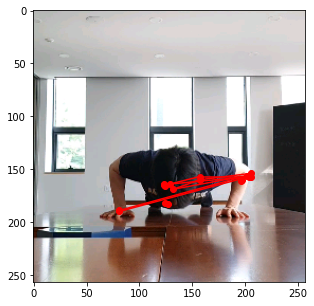

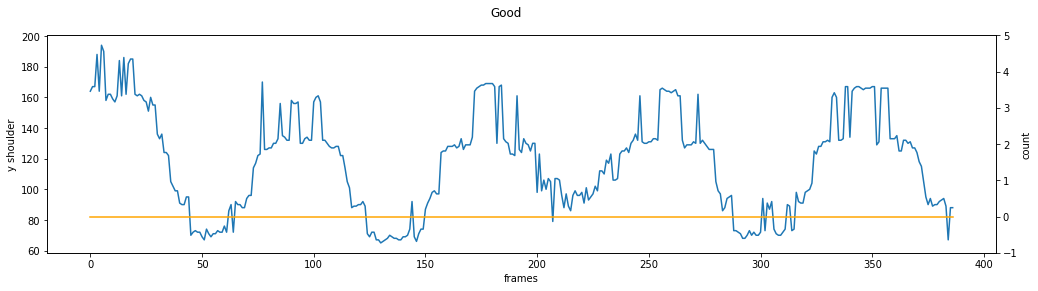

false_medium


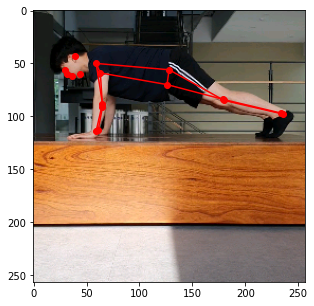

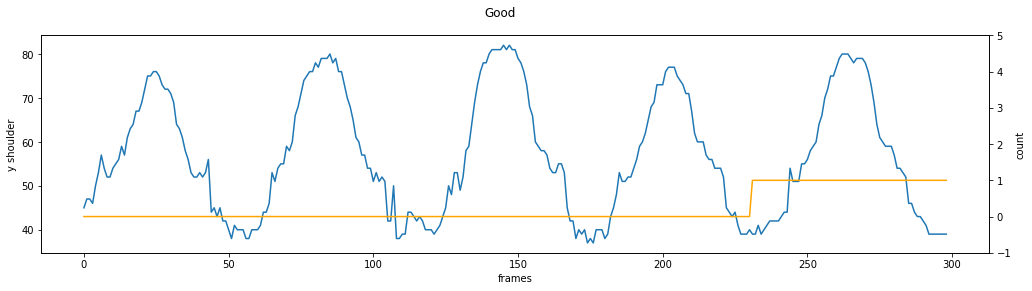

left_side_arm


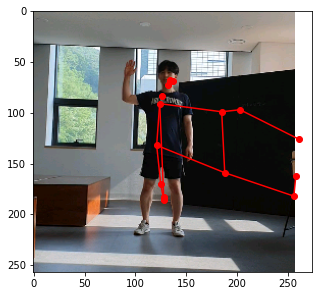

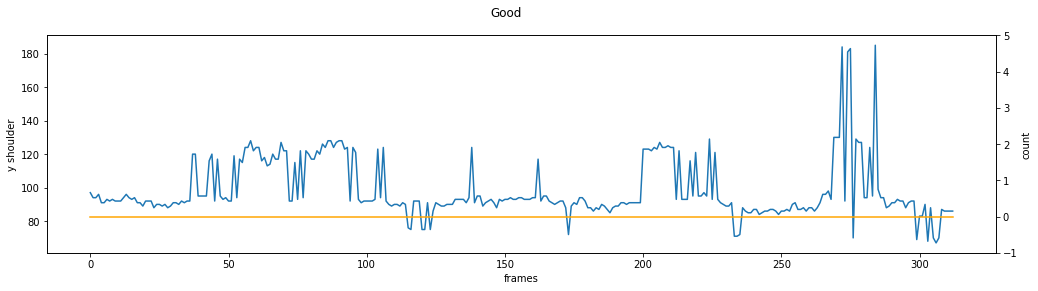

regular


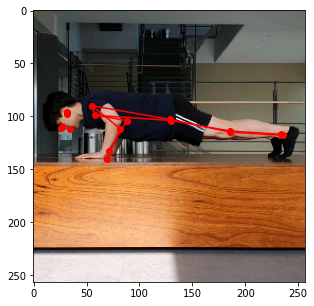

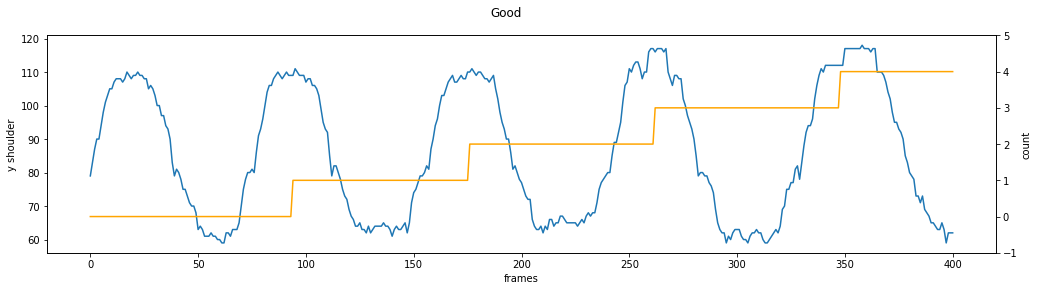

degree_45_wide


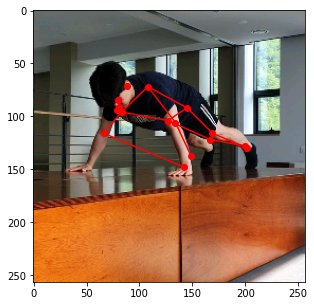

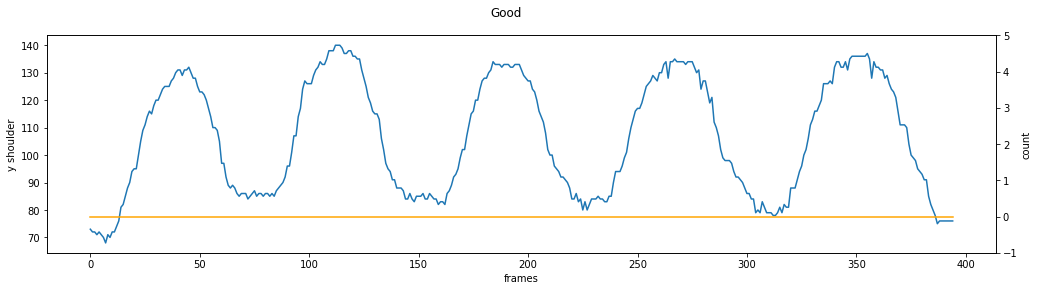

both_side_arm


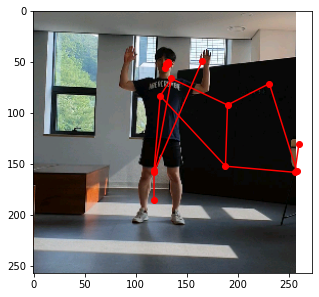

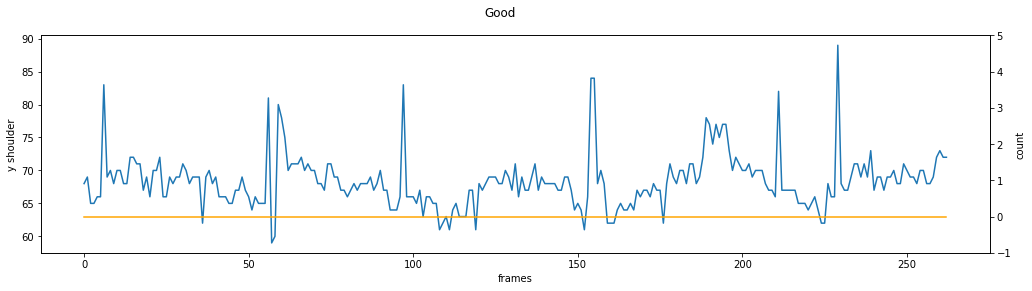

false_knee_on_bottom


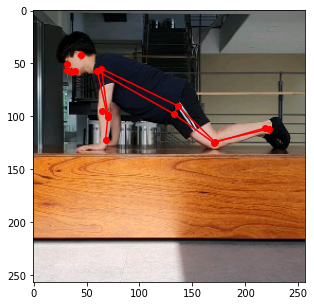

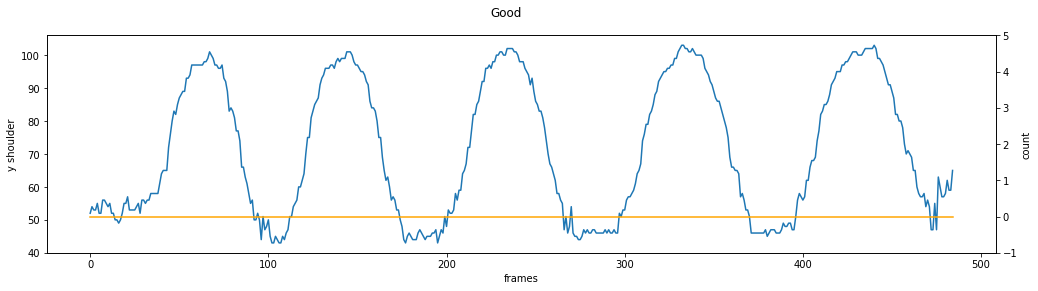

table


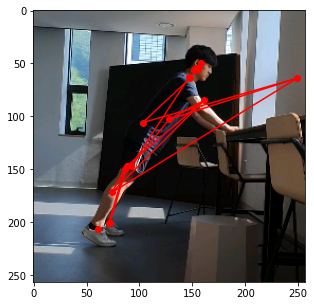

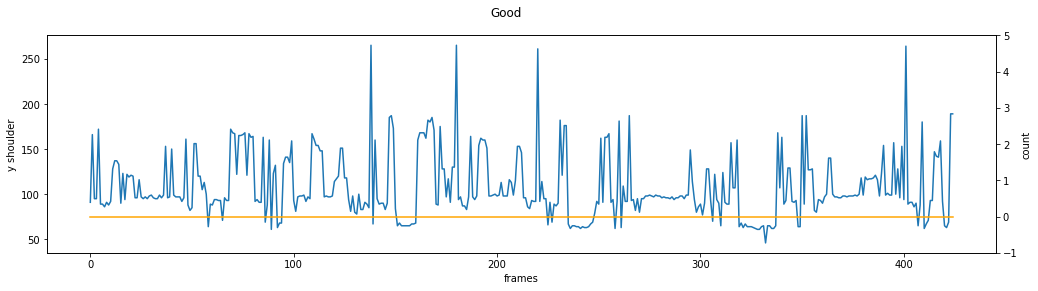

false_wall


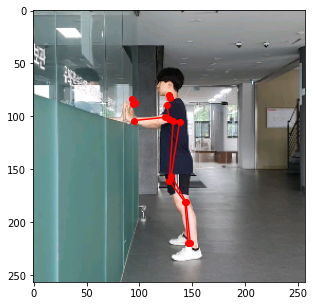

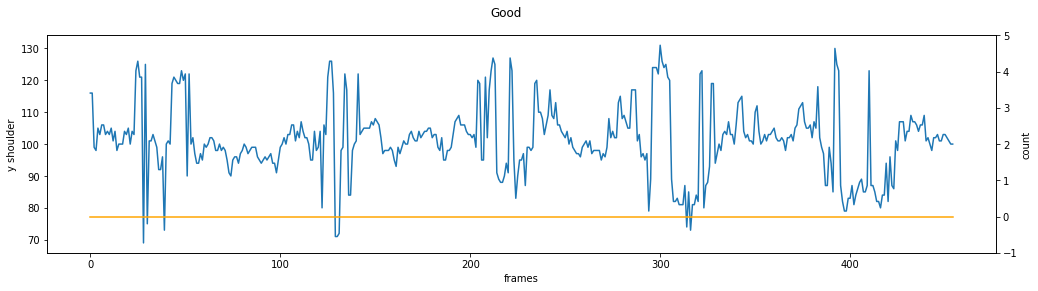

false_form


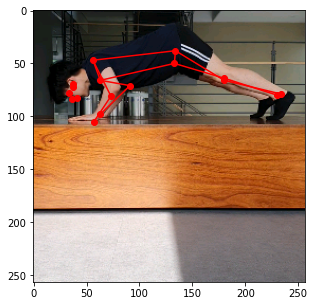

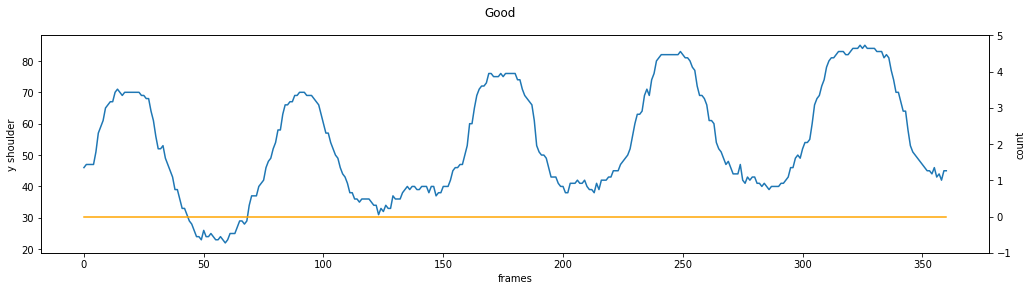

false_laying_on_floor


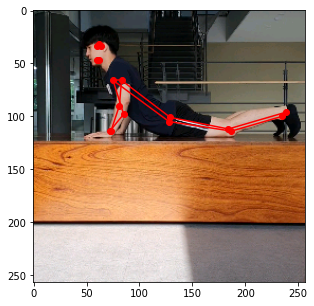

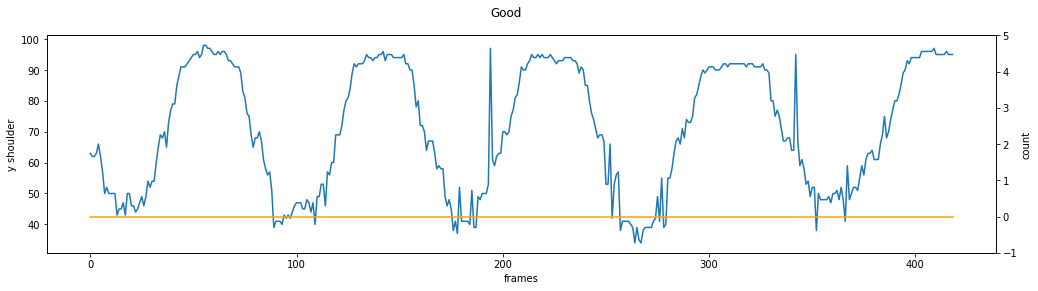

degree_45_narrow


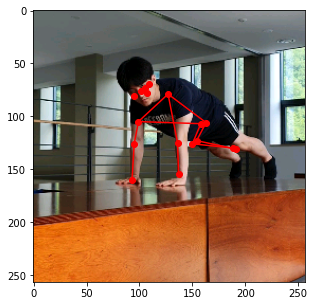

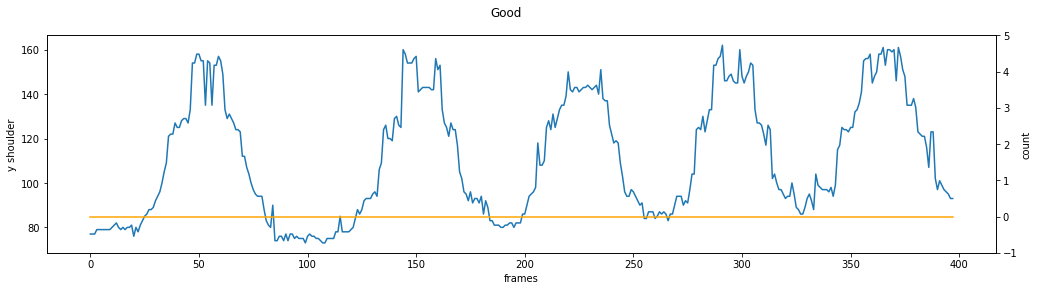

rear_view


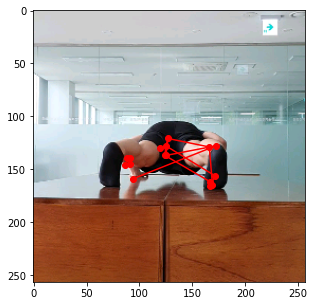

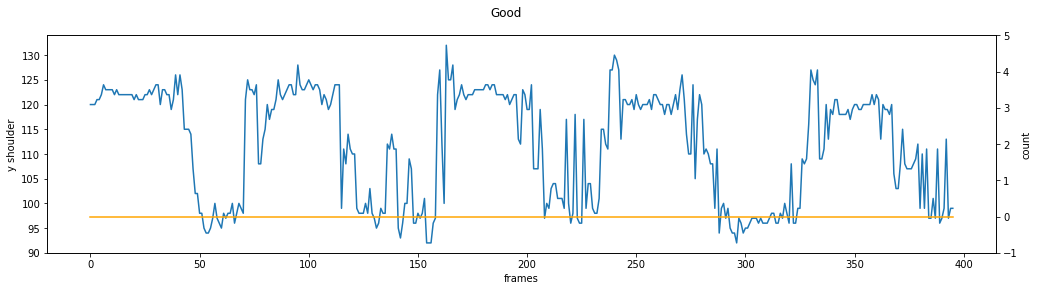

false_small


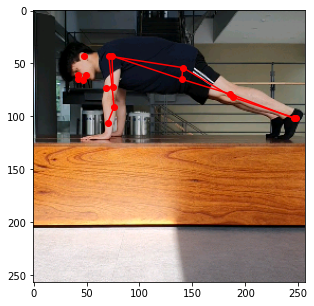

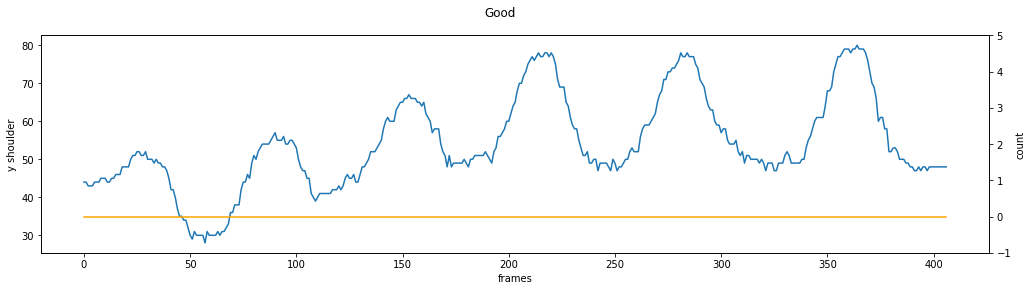

frontal_view


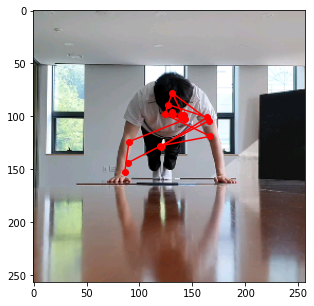

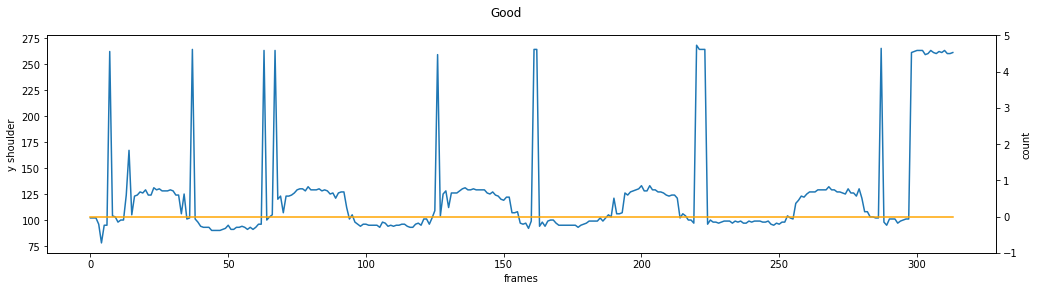

false_medium


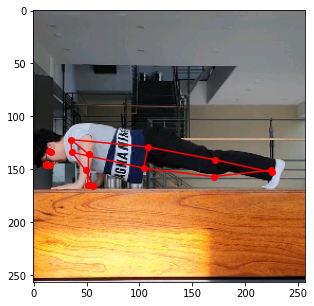

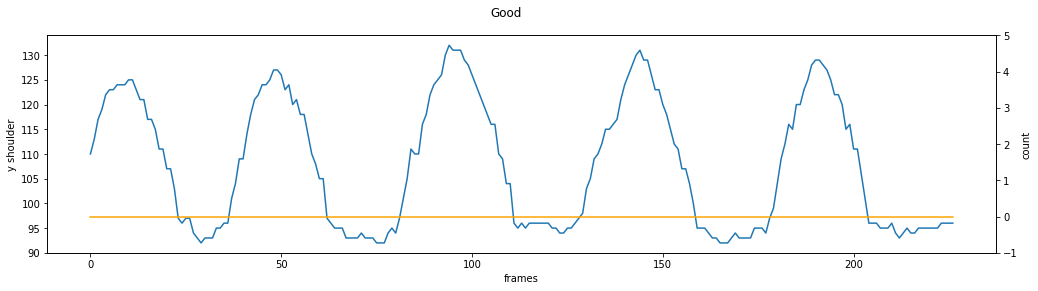

left_side_arm


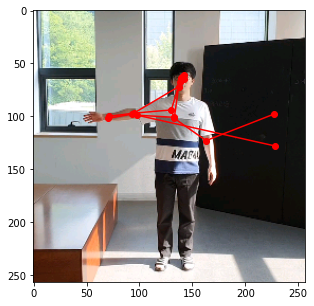

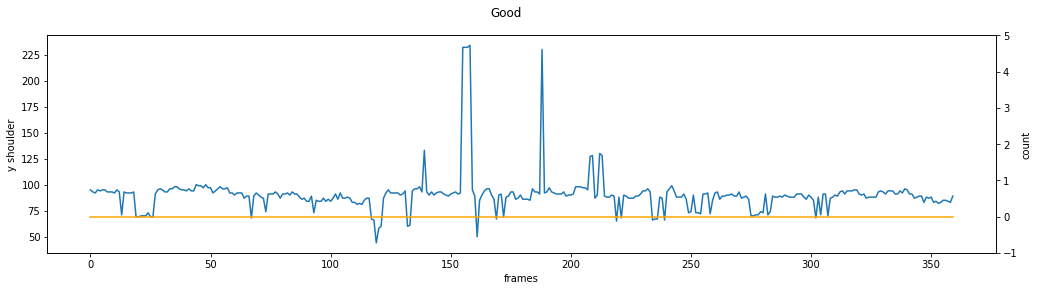

regular


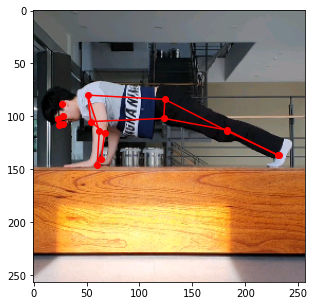

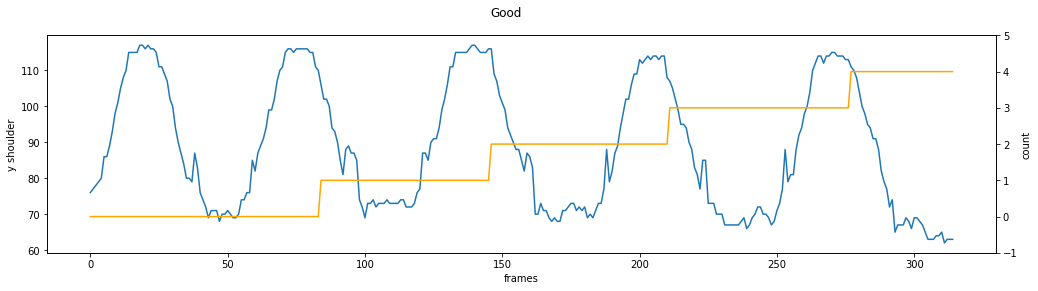

degree_45_wide


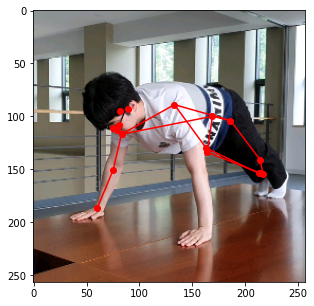

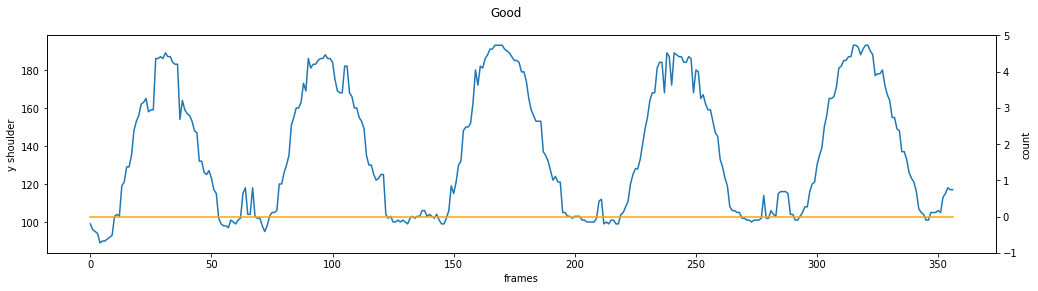

both_side_arm


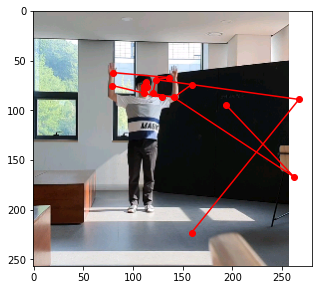

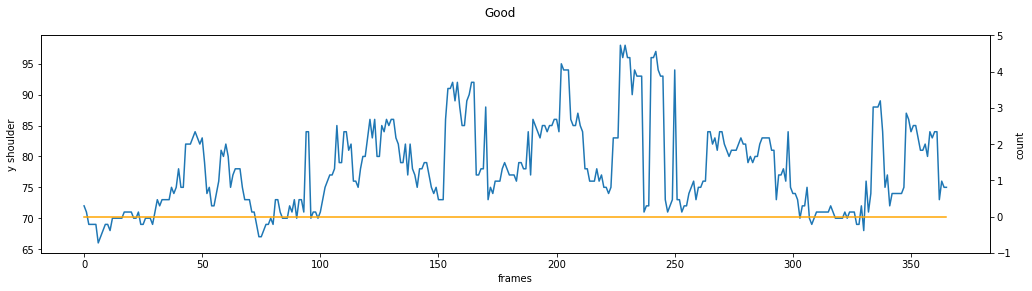

false_knee_on_bottom


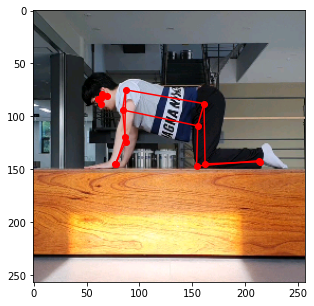

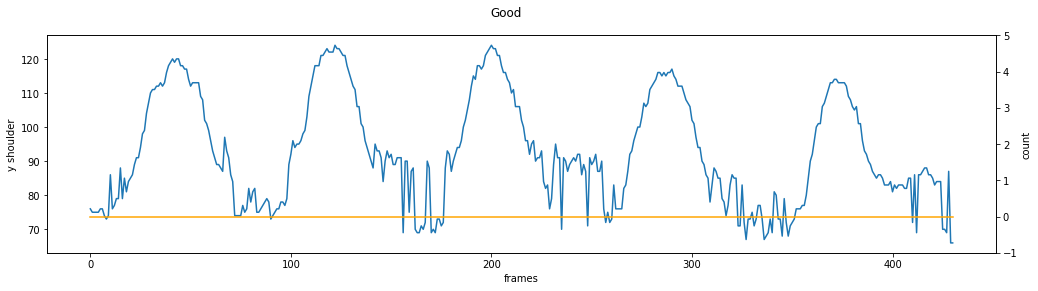

table


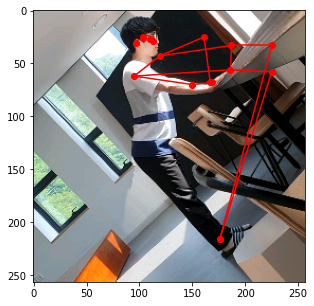

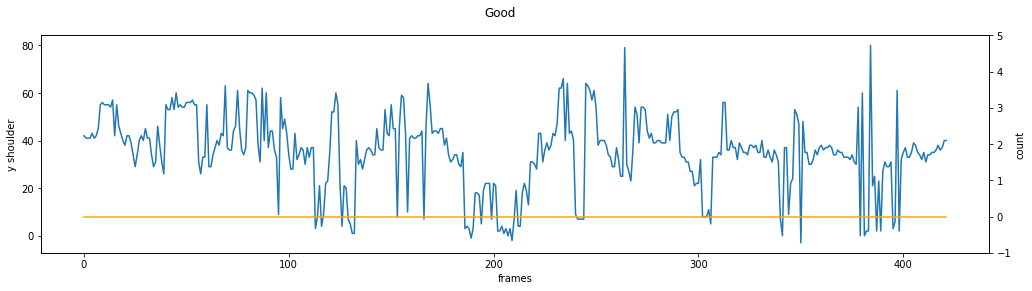

false_wall


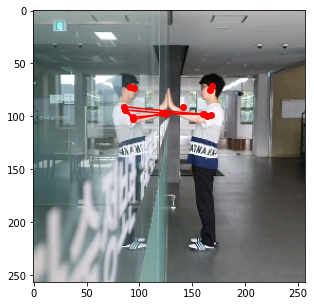

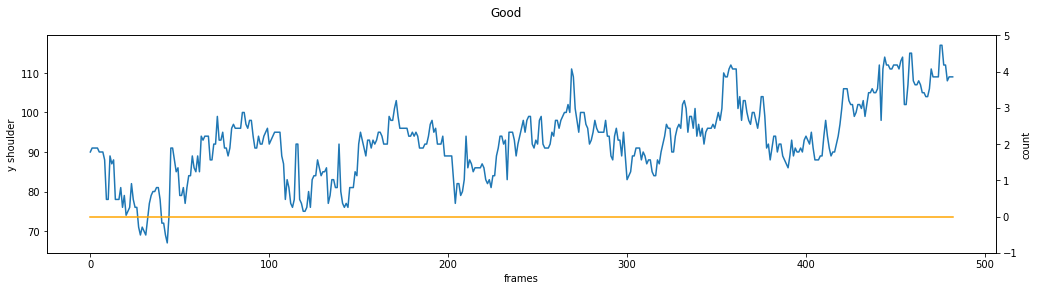

false_form


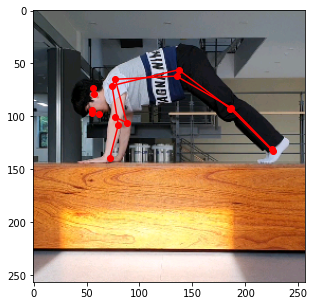

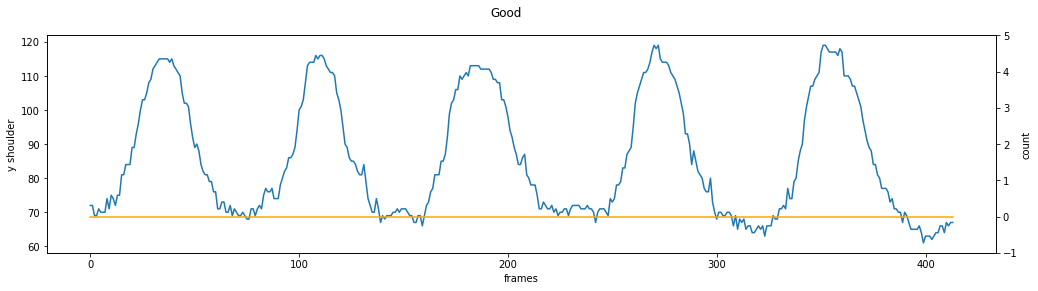

false_laying_on_floor


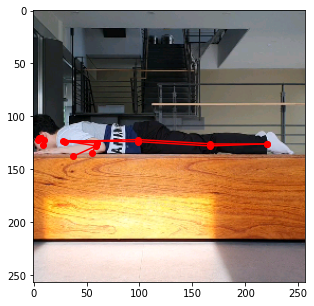

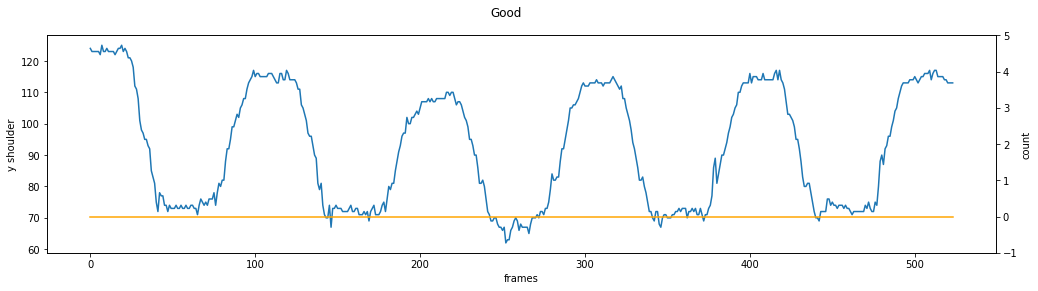

degree_45_narrow


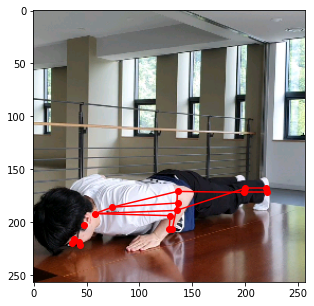

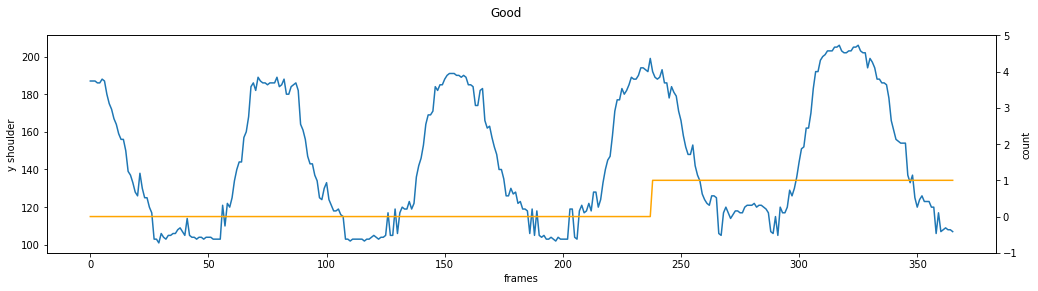

rear_view


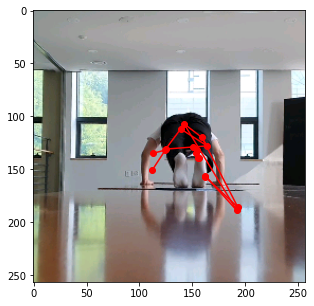

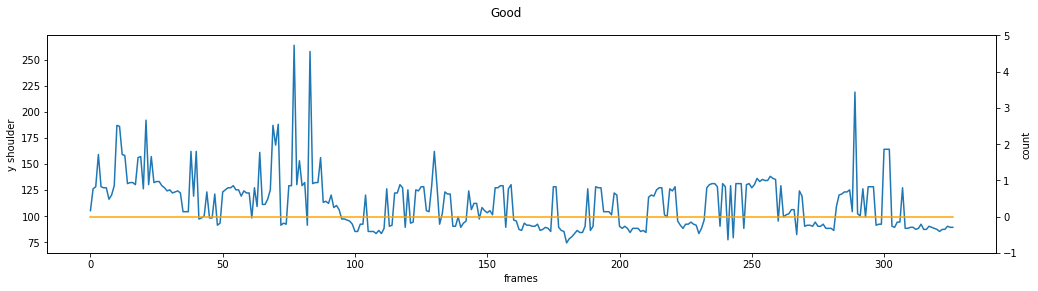

false_small


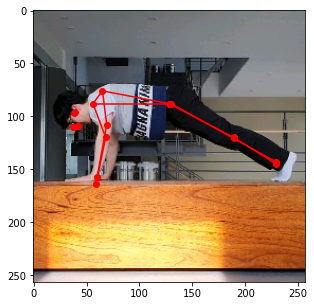

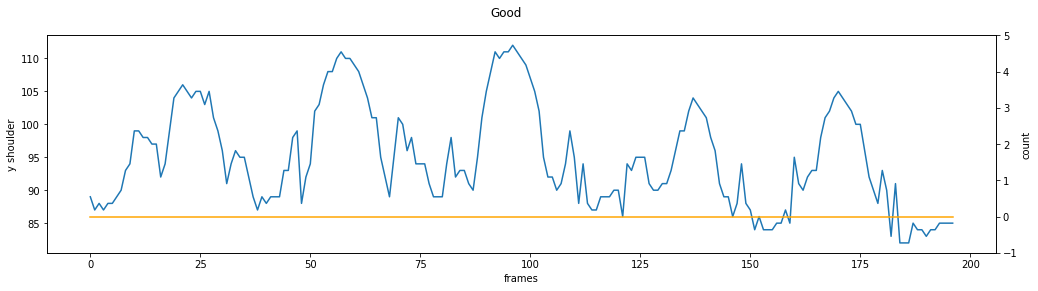

In [13]:
from collections import defaultdict

from scipy.signal import medfilt


def get_xyscore(inference_result, body_part):
    return inference_result[BODY_PART_TO_IDX[body_part]]

person_pushup_count_dict = defaultdict(dict)
for key, value in pos_sequences.items():
    person, pushup_type = key
    if pushup_type == 'narrow':
        continue
        
    # Draw sample image
    img = get_image(person, pushup_type, 120)
    fig, ax = plt.subplots(figsize=(5,5))
    print(pushup_type)
    ax.imshow(img)
    draw_skeleton(inference(img), ax)
    plt.show()
    
    
    # Draw y_shoulder and counts
    fig, ax = plt.subplots(figsize=(17,4))
    fig.suptitle('Good')
    pushup_counter = PushupCounter()
    counts = []
    y_shoulders = []
    for idx, inference_result in enumerate(value):
        count = pushup_counter.count(inference_result, idx)
        y_shoulder = get_xyscore(inference_result, 'LEFT_SHOULDER')[1]
        counts.append(count)
        y_shoulders.append(y_shoulder)
    ax.set_xlabel('frames')
    ax.set_ylabel('y shoulder')
    ax.plot(y_shoulders)
    
    ax2 = ax.twinx()
    ax2.set_ylim(-1,5)
    ax2.set_ylabel('count')
    ax2.plot(counts, color='orange')
    plt.show()
    
    sum_error = sum([pushup_counter.confidence_error_count, pushup_counter.shoulder_distance_error_count, pushup_counter.body_angle_error_count, pushup_counter.hip_angle_error_count, pushup_counter.knee_angle_error_count])
    total = value.shape[0]
    
    person_pushup_count_dict[person][pushup_type] = {
        'count': counts[-1],
        'success': (total - sum_error) / total,
        'confidence_error_count': pushup_counter.confidence_error_count / total,
        'shoulder_distance_error_count': pushup_counter.shoulder_distance_error_count / total,
        'body_angle_error_count': pushup_counter.body_angle_error_count / total,
        'hip_angle_error_count': pushup_counter.hip_angle_error_count / total,
        'knee_angle_error_count': pushup_counter.knee_angle_error_count / total,
    }

0.9975062344139651 0.0 0.0 0.0 0.0 0.0024937655860349127 
0.9732441471571907 0.0 0.023411371237458192 0.0 0.0033444816053511705 0.0 
1.0 0.0 0.0 0.0 0.0 0.0 
0.0 1.0 0.0 0.0 0.0 0.0 
0.0 0.9924242424242424 0.007575757575757576 0.0 0.0 0.0 
0.0 0.26582278481012656 0.660759493670886 0.005063291139240506 0.04050632911392405 0.027848101265822784 
0.0 1.0 0.0 0.0 0.0 0.0 
0.0 1.0 0.0 0.0 0.0 0.0 
0.16066481994459833 0.0 0.0221606648199446 0.0 0.817174515235457 0.0 
0.016494845360824743 0.0 0.008247422680412371 0.002061855670103093 0.09690721649484536 0.8762886597938144 
0.360381861575179 0.11217183770883055 0.0 0.14797136038186157 0.36992840095465396 0.00954653937947494 
0.0 1.0 0.0 0.0 0.0 0.0 


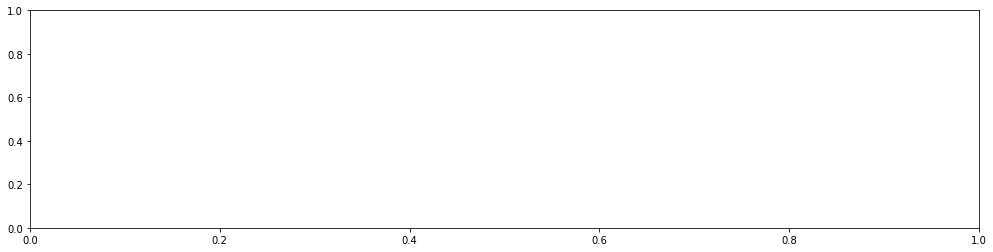

In [16]:
res_keys = ['count', 'success', 'confidence_error_count', 'shoulder_distance_error_count', 'body_angle_error_count', 'hip_angle_error_count', 'knee_angle_error_count']

fig, ax = plt.subplots(figsize=(17,4))
for person in ['hyunwoo']:
    for pushup_type in ['regular', 'false_medium', 'false_small', 'frontal_view', 'rear_view', 'degree_45_wide', 'both_side_arm', 'false_wall', 'false_form', 'false_knee_on_bottom', 'false_laying_on_floor', 'table']:
        for error in ['success', 'confidence_error_count', 'shoulder_distance_error_count', 'body_angle_error_count', 'hip_angle_error_count', 'knee_angle_error_count']:
            print(person_pushup_count_dict[person][pushup_type][error], end=' ')
        print()